In [2]:
import tensorflow as tf
import numpy as np



2025-11-04 09:51:50.960799: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-04 09:51:51.393361: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-04 09:51:54.022047: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
test_data = tf.keras.utils.image_dataset_from_directory(
    directory="../data/archive/test",  #? charge les images depuis ton dossier test
    labels='inferred',                 #? déduit les labels à partir des noms de sous-dossiers (angry, happy, etc.).
    label_mode='int',                  #? les labels seront des entiers (0, 1, 2...).
    image_size=(256, 256),             #? redimensionne toutes les images à 256×256.
    interpolation='nearest',
    batch_size=32,                     #? traite 32 images par batch.
    shuffle=True                       #? melange les images.
)

print("Classes :", test_data.class_names)


Found 7178 files belonging to 7 classes.
Classes : ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


2025-11-04 09:51:56.828700: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    directory="../data/archive/train",  
    labels='inferred',                
    label_mode='int',              
    image_size=(256, 256),           
    interpolation='nearest',
    batch_size=32,                    
    shuffle=True                       
)

print("Classes :", train_data.class_names)

Found 647 files belonging to 1 classes.
Classes : ['angry']


In [5]:
class_name = test_data.class_names
class_name

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [6]:
len(test_data)


225

In [7]:
len(train_data)

21

In [8]:

#! Verifier size d'images
for images_batch, labels_batch in test_data.take(1):  #? prend juste un batch
    print("Batch shape :", images_batch.shape)
    print("Label shape :", labels_batch.shape)
    print("Première image :", images_batch[0].shape)
    print("Premier label :", labels_batch[0].numpy())


Batch shape : (32, 256, 256, 3)
Label shape : (32,)
Première image : (256, 256, 3)
Premier label : 1


2025-11-04 09:51:57.120581: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
"""
  Ce code parcourt le premier lot (batch) d'images dans ton dataset test_data.

test_data.take(1) signifie prendre seulement 1 batch du dataset.

Chaque batch contient deux éléments :

image_size → les images (sous forme de tenseur, donc un tableau de pixels)

label → les étiquettes associées (par exemple “angry”, “happy”, etc.)

La ligne print(image_size) affiche donc le contenu du tenseur d'images,
c'est-à-dire les valeurs des pixels du premier batch.
  """
for image_size,label in test_data.take(1):
  print(image_size)

tf.Tensor(
[[[[209 209 209]
   [209 209 209]
   [209 209 209]
   ...
   [200 200 200]
   [200 200 200]
   [200 200 200]]

  [[209 209 209]
   [209 209 209]
   [209 209 209]
   ...
   [200 200 200]
   [200 200 200]
   [200 200 200]]

  [[209 209 209]
   [209 209 209]
   [209 209 209]
   ...
   [200 200 200]
   [200 200 200]
   [200 200 200]]

  ...

  [[204 204 204]
   [204 204 204]
   [204 204 204]
   ...
   [179 179 179]
   [179 179 179]
   [179 179 179]]

  [[204 204 204]
   [204 204 204]
   [204 204 204]
   ...
   [179 179 179]
   [179 179 179]
   [179 179 179]]

  [[204 204 204]
   [204 204 204]
   [204 204 204]
   ...
   [179 179 179]
   [179 179 179]
   [179 179 179]]]


 [[[ 22  22  22]
   [ 22  22  22]
   [ 22  22  22]
   ...
   [ 18  18  18]
   [ 18  18  18]
   [ 18  18  18]]

  [[ 22  22  22]
   [ 22  22  22]
   [ 22  22  22]
   ...
   [ 18  18  18]
   [ 18  18  18]
   [ 18  18  18]]

  [[ 22  22  22]
   [ 22  22  22]
   [ 22  22  22]
   ...
   [ 18  18  18]
   [ 18  18  18]


2025-11-04 09:51:57.171244: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


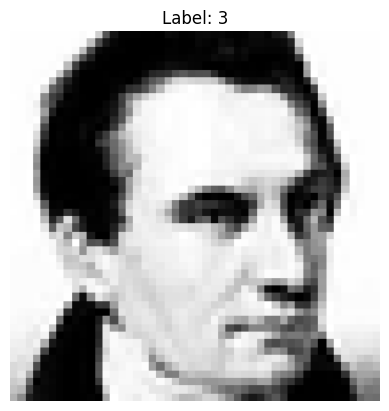

In [25]:
import matplotlib.pyplot as plt

for images, labels in test_data.take(1):
    plt.imshow(images[31].numpy().astype("uint8"))
    plt.title(f"Label: {labels[10].numpy()}")
    plt.axis("off")
    plt.show()
